In [1]:
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
import random
import seaborn as sns

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from bidict import bidict

import sys

from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers
from keras.layers import *
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

In [2]:
ENCODER = bidict({
    'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6,
    'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12,
    'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18,
    'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24,
    'Y': 25, 'Z': 26, 'a': 27, 'b': 28, 'c': 29, 'd': 30,
    'e': 31, 'f': 32, 'g': 33, 'h': 34, 'i': 35, 'j': 36,
    'k': 37, 'l': 38, 'm': 39, 'n': 40, 'o': 41, 'p': 42,
    'q': 43, 'r': 44, 's': 45, 't': 46, 'u': 47, 'v': 48,
    'w': 49, 'x': 50, 'y': 51, 'z': 52
})

### Load labels

In [3]:
labels = np.load('../data/labels.npy')
labels[0:5]

array(['u', 'm', 'r', 'N', 'A'], dtype='<U1')

### Load images

In [4]:
imgs = np.load('../data/images.npy')
imgs[0:2]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

### Distribution of Letters

Number of Classes: 52
Number of Data Points: 1300


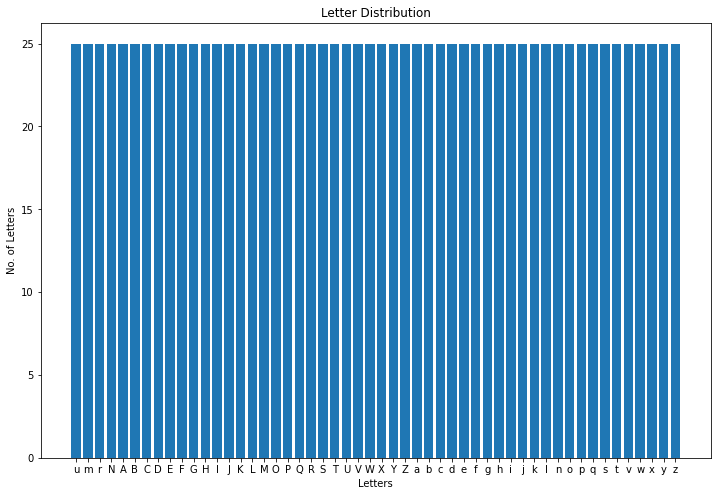

In [5]:
data = {}

for label in labels:
    data[label] = data.get(label, 0) + 1

data = sorted(data.items(), key=lambda x: x[1], reverse=True)

x = [d[0] for d in data]
y = [d[1] for d in data]

print(f"Number of Classes: {len(data)}")
print(f"Number of Data Points: {len(labels)}")

fig = plt.figure(figsize = (12, 8))
plt.bar(x, y)
plt.xlabel("Letters")
plt.ylabel("No. of Letters")
plt.title("Letter Distribution")
plt.show()

### Encode labels from ENCODER dictionary

In [6]:
labels = np.array([ENCODER[x] for x in labels])
labels[0:5]

array([47, 39, 44, 14,  1])

In [7]:
labels.shape

(1300,)

### Expand shape of image to 4D

In [8]:
imgs = np.expand_dims(imgs, -1)

In [9]:
imgs.shape

(1300, 50, 50, 1)

### Create a training and validation split

In [10]:
x_train, x_val, y_train, y_val  = train_test_split(imgs, labels,
                                                   train_size = 0.80,
                                                   test_size = 0.20,
                                                   random_state = 45)

### Reshape and Normalize train and validation data

In [11]:
x_train = x_train / 255.0
x_val = x_val / 255.0

print(f"Training set: {x_train.shape, y_train.shape}")
print(f"Validation set: {x_val.shape, y_val.shape}")

Training set: ((1040, 50, 50, 1), (1040,))
Validation set: ((260, 50, 50, 1), (260,))


### View sample images of the training set

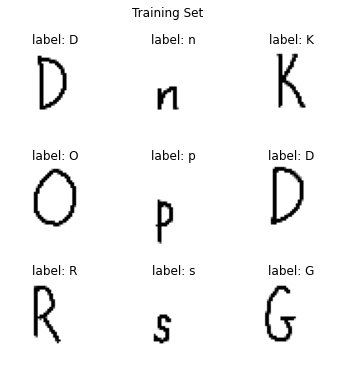

In [12]:
train_samples = random.sample(range(0, len(x_train)), 9)

x_train

plt.figure(figsize=(6,6))
plt.suptitle('Training Set')

for i in train_samples:
  plt.subplot(3, 3, train_samples.index(i) + 1)
  plt.imshow(x_train[i, :], cmap = 'binary')
  plt.title(f'label: {ENCODER.inverse[y_train[i]]}')
  plt.axis('off')

### Create CNN Model

In [13]:
'''
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(50, 50, 1)),
    layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    layers.MaxPool2D(pool_size=2),
    layers.Dropout(0.2),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    layers.MaxPool2D(pool_size=2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(len(ENCODER) + 1, activation = 'softmax')
])
'''

"\nmodel = tf.keras.models.Sequential([\n    tf.keras.Input(shape=(50, 50, 1)),\n    layers.Conv2D(filters=32, kernel_size=3, activation='relu'),\n    layers.MaxPool2D(pool_size=2),\n    layers.Dropout(0.2),\n    layers.Conv2D(filters=64, kernel_size=3, activation='relu'),\n    layers.MaxPool2D(pool_size=2),\n    layers.Dropout(0.2),\n    layers.Flatten(),\n    layers.Dense(len(ENCODER) + 1, activation = 'softmax')\n])\n"

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(50, 50, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(len(ENCODER) + 1, activation = 'softmax')
])

In [15]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1, mode = 'min')
mcp_save = ModelCheckpoint('letters_model.h5', save_best_only = True, monitor = 'val_loss', verbose = 1, mode = 'auto')
optimizer = tf.keras.optimizers.Adam()

In [16]:
model.compile(loss = 'sparse_categorical_crossentropy',
     optimizer = optimizer,
     metrics = ['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 11, 11, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          3

### Train the Model

In [18]:
# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

# prepare iterator
it_train = datagen.flow(x_train, y_train, batch_size=10)

steps = int(x_train.shape[0] / 10)

In [19]:
#history = model.fit(x_train, y_train, epochs = 100,
#                    validation_data = (x_val, y_val),
#                    batch_size = 16, verbose = 1,
#                    callbacks = [early_stopping, mcp_save])
history = model.fit(it_train, steps_per_epoch = steps, 
                    epochs = 100, validation_data = (x_val, y_val), verbose = 1,
                   callbacks = [early_stopping, mcp_save])

Epoch 1/100
104/104 [==============================] - ETA: 0s - loss: 3.9242 - accuracy: 0.0356
Epoch 1: val_loss improved from inf to 3.65994, saving model to letters_model.h5
104/104 [==============================] - 2s 13ms/step - loss: 3.9242 - accuracy: 0.0356 - val_loss: 3.6599 - val_accuracy: 0.0500
Epoch 2/100
103/104 [============================>.] - ETA: 0s - loss: 3.1748 - accuracy: 0.1592
Epoch 2: val_loss improved from 3.65994 to 2.11161, saving model to letters_model.h5
104/104 [==============================] - 1s 12ms/step - loss: 3.1768 - accuracy: 0.1587 - val_loss: 2.1116 - val_accuracy: 0.3462
Epoch 3/100
103/104 [============================>.] - ETA: 0s - loss: 2.1977 - accuracy: 0.3417
Epoch 3: val_loss improved from 2.11161 to 1.22208, saving model to letters_model.h5
104/104 [==============================] - 1s 12ms/step - loss: 2.1973 - accuracy: 0.3413 - val_loss: 1.2221 - val_accuracy: 0.5769
Epoch 4/100
102/104 [============================>.] - ETA: 0s

### Plotting the losses and accuracy of training and validation datasets

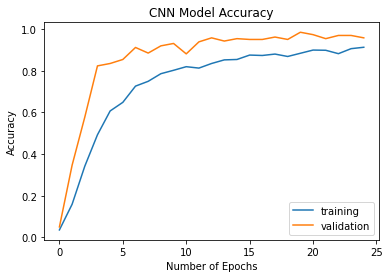

In [20]:
# plot training vs validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(['training', 'validation'], loc='lower right')

plt.show()

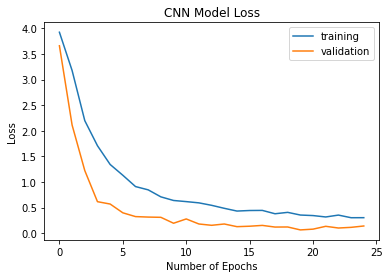

In [21]:
# Plot training vs validation losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(['training', 'validation'], loc='upper right')

plt.show()

### Evaluation

In [22]:
labels_pred = np.argmax(model.predict(x_val), axis = 1)

9/9 [==============================] - 0s 6ms/step


In [23]:
cm = confusion_matrix(y_val, labels_pred, labels = list(ENCODER.inverse.keys()))

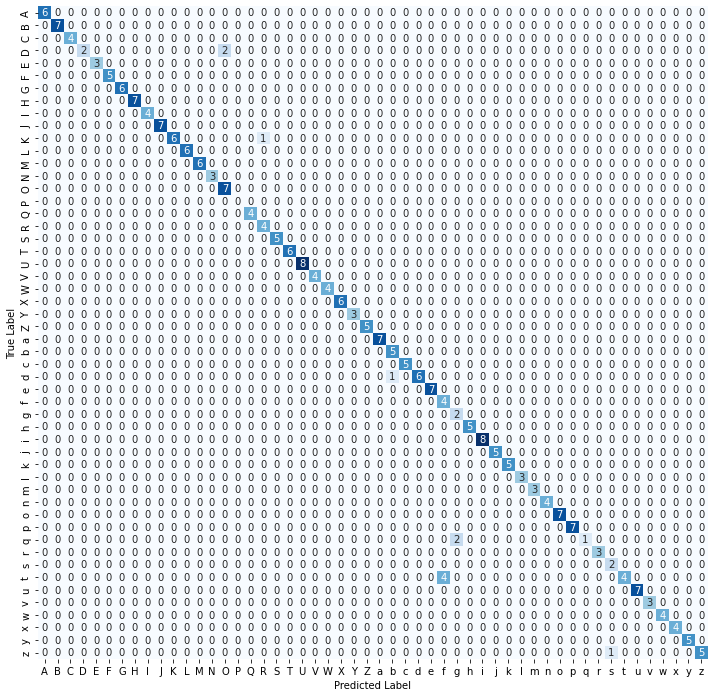

In [24]:
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, annot=True, cbar=False, cmap="Blues", xticklabels=list(ENCODER.keys()), yticklabels=list(ENCODER.keys()))
ax.set(ylabel="True Label", xlabel="Predicted Label")
plt.show()